## Решение задач по аналитике мобильной игры (Retention, A/B-тесты, метрики событий)

Цель проекта:

Провести анализ ключевых метрик мобильной игры, включая расчет Retention Rate, оценку результатов A/B-теста акционных предложений и предложение метрик для оценки тематического события.

Задачи:

1. Разработать функцию на Python для расчета Retention Rate по дням от даты регистрации пользователей.

2. A/B-тестирование акционных предложений
- Определить, какой набор акционных предложений (группа A или B) показал лучшие результаты.
- Предложить систему метрик, которые помогут измерить успешность эксперимента
- Оценить статистическую значимость различий между группами.

# Загрузка и предобработка данных

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import ttest_ind
import numpy as np
import statsmodels.api as sm
import requests
from tqdm import tqdm
from datetime import datetime, timedelta
import pingouin as pg

Таблица reg_data, которая содержит данные о времени регистрации

In [2]:
reg_data=pd.read_csv('problem1-reg_data.csv', sep=';')
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


Таблица auth_data, которая содержит данные о времени захода пользователей в игру

In [6]:
auth_data=pd.read_csv('problem1-auth_data.csv', sep=';')
auth_data

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


Проверим на наличие дубликатов

In [7]:
int(reg_data.duplicated().sum())

0

In [8]:
int(auth_data.duplicated().sum())

0

In [9]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [10]:
auth_data.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [11]:
reg_data.uid.nunique()==auth_data.uid.nunique()

True

Дубликаты отсутствуют. Проверим наличие пропущенных значений

In [12]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [13]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Пропущенные значения также отсутствуют

Проверим типы данных

In [14]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [15]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

Обе таблицы содержат в себе данные о времени, но типы данных не соответвуют необходимым. Проведем преобразование типов данных

In [16]:
reg_data['registration_time']= pd.to_datetime(reg_data['reg_ts'], unit='s')
reg_data['registration_date']= pd.to_datetime(reg_data['reg_ts'], unit='s').dt.to_period('D')
auth_data['time_to_game']= pd.to_datetime(auth_data['auth_ts'], unit='s')
auth_data['auth_date']= pd.to_datetime(auth_data['auth_ts'], unit='s').dt.to_period('D')

In [17]:
reg_data

,reg_ts,uid,registration_time,registration_date
0,911382223,1,1998-11-18 09:43:43,1998-11-18
1,932683089,2,1999-07-22 22:38:09,1999-07-22
2,947802447,3,2000-01-13 22:27:27,2000-01-13
3,959523541,4,2000-05-28 14:19:01,2000-05-28
4,969103313,5,2000-09-16 11:21:53,2000-09-16
...,...,...,...,...
999995,1600874034,1110618,2020-09-23 15:13:54,2020-09-23
999996,1600874086,1110619,2020-09-23 15:14:46,2020-09-23
999997,1600874139,1110620,2020-09-23 15:15:39,2020-09-23
999998,1600874191,1110621,2020-09-23 15:16:31,2020-09-23


In [18]:
auth_data

,auth_ts,uid,time_to_game,auth_date
0,911382223,1,1998-11-18 09:43:43,1998-11-18
1,932683089,2,1999-07-22 22:38:09,1999-07-22
2,932921206,2,1999-07-25 16:46:46,1999-07-25
3,933393015,2,1999-07-31 03:50:15,1999-07-31
4,933875379,2,1999-08-05 17:49:39,1999-08-05
...,...,...,...,...
9601008,1600874034,1110618,2020-09-23 15:13:54,2020-09-23
9601009,1600874086,1110619,2020-09-23 15:14:46,2020-09-23
9601010,1600874139,1110620,2020-09-23 15:15:39,2020-09-23
9601011,1600874191,1110621,2020-09-23 15:16:31,2020-09-23


In [19]:
reg_data.dtypes

reg_ts                        int64
uid                           int64
registration_time    datetime64[ns]
registration_date         period[D]
dtype: object

In [20]:
auth_data.dtypes

auth_ts                  int64
uid                      int64
time_to_game    datetime64[ns]
auth_date            period[D]
dtype: object

Преобразования в дату прошли успешно

Теперь для дальнейшей работы необходимо соединить две таблицы по общему ключу - uid (айдишник пользователя в игре)

In [21]:
user_activity = auth_data.merge(reg_data, on='uid', how='left')
user_activity

,auth_ts,uid,time_to_game,auth_date,reg_ts,registration_time,registration_date
0,911382223,1,1998-11-18 09:43:43,1998-11-18,911382223,1998-11-18 09:43:43,1998-11-18
1,932683089,2,1999-07-22 22:38:09,1999-07-22,932683089,1999-07-22 22:38:09,1999-07-22
2,932921206,2,1999-07-25 16:46:46,1999-07-25,932683089,1999-07-22 22:38:09,1999-07-22
3,933393015,2,1999-07-31 03:50:15,1999-07-31,932683089,1999-07-22 22:38:09,1999-07-22
4,933875379,2,1999-08-05 17:49:39,1999-08-05,932683089,1999-07-22 22:38:09,1999-07-22
...,...,...,...,...,...,...,...
9601008,1600874034,1110618,2020-09-23 15:13:54,2020-09-23,1600874034,2020-09-23 15:13:54,2020-09-23
9601009,1600874086,1110619,2020-09-23 15:14:46,2020-09-23,1600874086,2020-09-23 15:14:46,2020-09-23
9601010,1600874139,1110620,2020-09-23 15:15:39,2020-09-23,1600874139,2020-09-23 15:15:39,2020-09-23
9601011,1600874191,1110621,2020-09-23 15:16:31,2020-09-23,1600874191,2020-09-23 15:16:31,2020-09-23


Проверим наличие багов. Заходили ли пользователи в игру до регистрации ?

In [22]:
user_activity['is_time_to_game_earlier'] = user_activity['time_to_game'] < user_activity['registration_time']

In [23]:
user_activity.is_time_to_game_earlier.value_counts()

is_time_to_game_earlier
False    9601013
Name: count, dtype: int64

Целостность данных проверена, случаев входа в игру до регистрации не обнаружено (все значения time_to_game >= registration_time)

Определим дипопзон дат регистраций и авторизаций игроков

In [24]:
total_days_reg=user_activity['registration_time'].max()-user_activity['registration_time'].min()
years_reg = total_days_reg.days / 365.25  
print(f"Период: {years_reg:.1f} лет")


Период: 21.8 лет


In [25]:
total_days_aut=user_activity['time_to_game'].max()-user_activity['time_to_game'].min()
years_aut = total_days_aut.days / 365.25  
print(f"Период: {years_aut:.1f} лет")

Период: 21.8 лет


Определим активность регистрации и авторизации за все 22 года

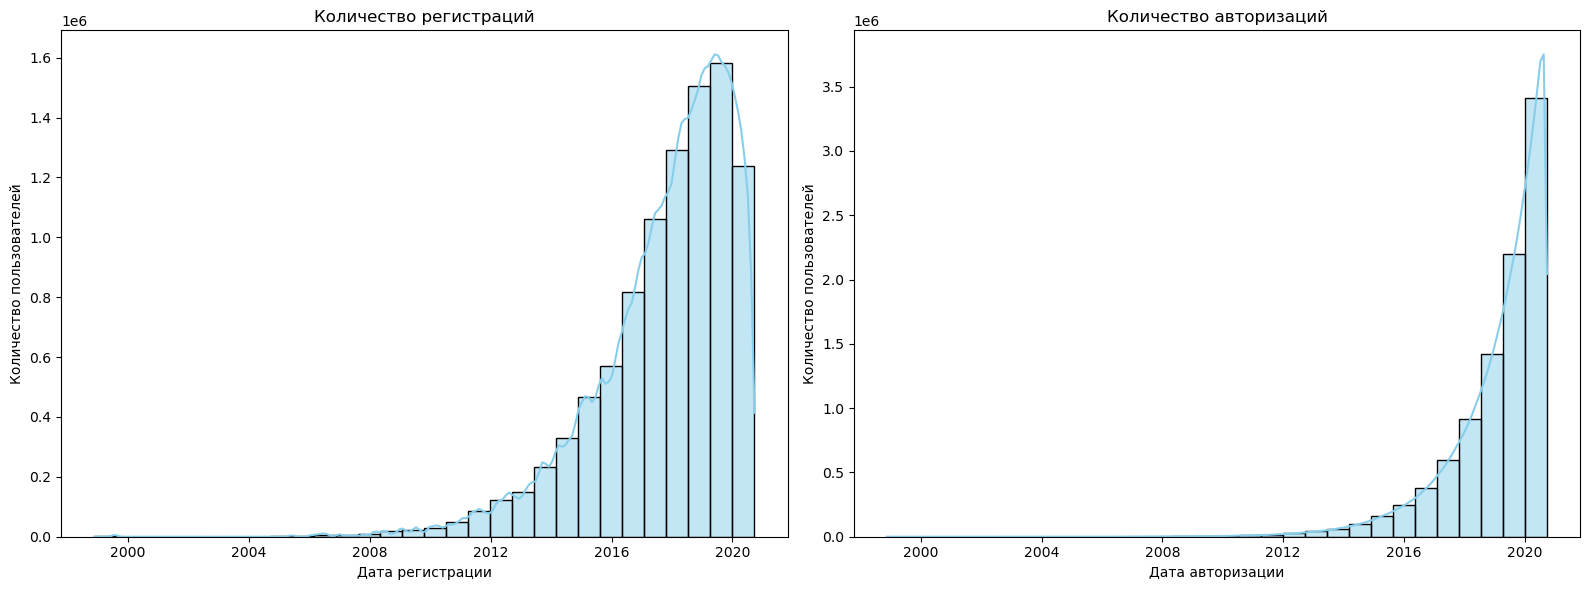

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(user_activity['registration_time'], bins=30, kde=True, ax=ax1, color='skyblue')
ax1.set_title('Количество регистраций')
ax1.set_xlabel('Дата регистрации')
ax1.set_ylabel('Количество пользователей')

sns.histplot(user_activity['time_to_game'], bins=30, kde=True, ax=ax2, color='skyblue')
ax2.set_title('Количество авторизаций')
ax2.set_xlabel('Дата авторизации')
ax2.set_ylabel('Количество пользователей')

plt.tight_layout()
plt.show()

Наглядно видно, что активность как регистраций, так и авторизаций начинает постепенно увеличиваться с 2012 года, наибольшая активность наблюдается с 2016 года

# Расчёт Retention Rate в мобильной игре

Retention – один из самых важных показателей в компании. 

Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

Для расчёта Retention Rate будем использовать метод когортного анализа.

In [44]:
def Nday_retention(start_date, end_date, Ndays_for_analyze):
    '''
    Функция для расчета N-day retention. 
    Принимает следующие аргументы:
    1. start_date - начало периода анализа (первая когорта) в формате 'YYYY-MM-DD'
    2. end_date - конец периода анализа (последняя когорта) в формате 'YYYY-MM-DD'
    3. Ndays_for_analyze - принимает список с номерами дней для анализа
    '''
    
    # Считывание и преобразование данных
    reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')
    auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')
    
    # Преобразование в datetime и извлечение даты
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date
    
    # Преобразование входных дат
    start_date = pd.to_datetime(start_date).date()
    end_date = pd.to_datetime(end_date).date()
    
    nday_list = []
    unavailable_nday = []
    
    # Проверка доступности дней для анализа
    for day in Ndays_for_analyze:
        if (start_date + timedelta(days=day)) <= reg_data['reg_ts'].max():
            nday_list.append(day)
        else:
            unavailable_nday.append(day)
    
    if unavailable_nday:
        days_text = "N-day" if len(unavailable_nday) == 1 else "N-days"
        print(f"{days_text} {unavailable_nday} для когорт {start_date} - {end_date} на данный момент не наступил(и).")
    
    # Объединение данных и расчет retention
    retention_df = reg_data.merge(auth_data, on='uid', how='right')[['uid', 'reg_ts', 'auth_ts']]
    
    # Расчет разницы в днях (исправленная строка)
    retention_df['day'] = (retention_df['auth_ts'] - retention_df['reg_ts']).apply(lambda x: x.days)
    
    retention_table = retention_df.query('day >= 0').groupby(['reg_ts', 'day'])['uid'].nunique().reset_index()
    registration_user_count = retention_df.groupby('reg_ts')['uid'].nunique().reset_index()
    registration_user_count.columns = ['reg_ts', 'cohort_size']
    
    retention_table = retention_table.merge(registration_user_count, on='reg_ts')
    retention_table['retention'] = retention_table['uid'] / retention_table['cohort_size']
    
    pivot_retention = retention_table.pivot_table(index='reg_ts', columns='day', values='retention')
    
    # Формирование результата
    if not nday_list:
        return pd.DataFrame()  # Возвращаем пустой DataFrame, если нет доступных дней
    
    retention_output = pd.DataFrame(pivot_retention[nday_list]).reset_index()
    retention_output = retention_output[(retention_output['reg_ts'] >= start_date) & 
                                      (retention_output['reg_ts'] <= end_date)]
    
    # Форматирование вывода
    for col in retention_output.columns[1:]:
        retention_output[col] = retention_output[col].apply(lambda x: f"{x*100:.2f}%" if pd.notnull(x) else "")
    
    retention_output = retention_output.rename(columns={'reg_ts': 'cohort_day'})
    
    return retention_output

In [45]:
start_date = '2019-12-01'
end_date = '2019-12-31'
Ndays_for_analyze = [1,3,7,14,30,60,90]
Nday_retention(start_date, end_date, Ndays_for_analyze)

day,cohort_day,1,3,7,14,30,60,90
4812,2019-12-01,2.08%,4.07%,6.05%,4.37%,3.27%,0.79%,1.29%
4813,2019-12-02,2.67%,4.15%,6.63%,5.04%,2.97%,1.29%,1.38%
4814,2019-12-03,1.88%,4.74%,6.72%,4.45%,2.96%,1.38%,1.48%
4815,2019-12-04,1.58%,4.04%,6.51%,3.35%,2.47%,0.79%,0.69%
4816,2019-12-05,2.07%,4.73%,5.71%,4.83%,2.66%,1.77%,1.38%
4817,2019-12-06,2.36%,4.92%,5.70%,4.23%,2.56%,1.87%,1.18%
4818,2019-12-07,1.77%,5.69%,6.38%,5.50%,2.65%,1.08%,0.88%
4819,2019-12-08,2.25%,5.00%,4.70%,4.60%,3.53%,0.59%,1.76%
4820,2019-12-09,2.64%,4.60%,5.97%,5.58%,3.03%,1.27%,1.08%
4821,2019-12-10,2.25%,5.27%,6.35%,4.10%,2.15%,1.46%,1.46%


# Анализ A/B-теста: сравнение эффективности акционных предложений в мобильной игре

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [3]:
A_B=pd.read_csv('A_B_test.csv', sep=';')
A_B

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Необходимо провести предобработку данных.

Определяем наличие пропущенных значений:

In [4]:
A_B.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Пропуски отсутствуют. Определим есть ли дубликаты в таблице:

In [5]:
int(A_B.duplicated().sum())

0

Дубликаты также отсутствуют. 

Проверяем распределение пользователей по группам

In [6]:
A_B['testgroup'].value_counts()

testgroup
b    202667
a    202103
Name: count, dtype: int64

In [7]:
round(202667/202103,2)

1.0

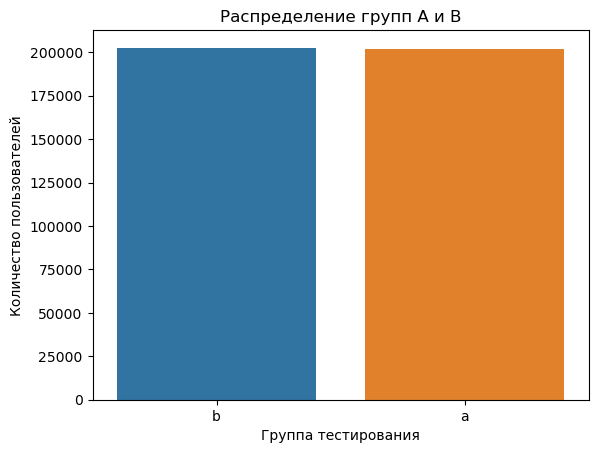

In [8]:
sns.countplot(data=A_B, x='testgroup', 
              hue='testgroup',
              palette=['#1f77b4', '#ff7f0e']) 

plt.title('Распределение групп A и B')
plt.xlabel('Группа тестирования')
plt.ylabel('Количество пользователей')
plt.show()

Распределение пользователей корректно, так как близко к 50/50

Определим корректность маркировки групп. Находятся ли пользователи одновременно в обеих группах

In [9]:
users_a = set(A_B[A_B['testgroup'] == 'a']['user_id'])
users_b = set(A_B[A_B['testgroup'] == 'b']['user_id'])
users_a & users_b  # Пересечение множеств

set()

В данных нет ни одного пользователя, который одновременно находился бы в обеих тестовых группах, все пользователи уникальны.

Определим активность пользователей. Существуют ли пользователи, которые не совершили ни одного действия?

In [10]:
zero_activity = A_B.groupby('user_id')['revenue'].sum() == 0
zero_activity.value_counts()  

revenue
True     401037
False      3733
Name: count, dtype: int64

Количество пользователей, у которых суммарный доход (revenue) равен 0 (неактивные пользователи, не совершившие ни одного платежа) составляет 401037

Количество пользователей с доходом > 0 (активные платящие пользователи) составляет 3733

Определим активность в каждой из групп

In [11]:
A_B['is_active'] = A_B.groupby('user_id')['revenue'].transform('sum') > 0

In [12]:
activity_by_group = A_B.groupby(['testgroup', 'is_active']).size().unstack()
print(activity_by_group)

is_active   False  True 
testgroup               
a          200175   1928
b          200862   1805


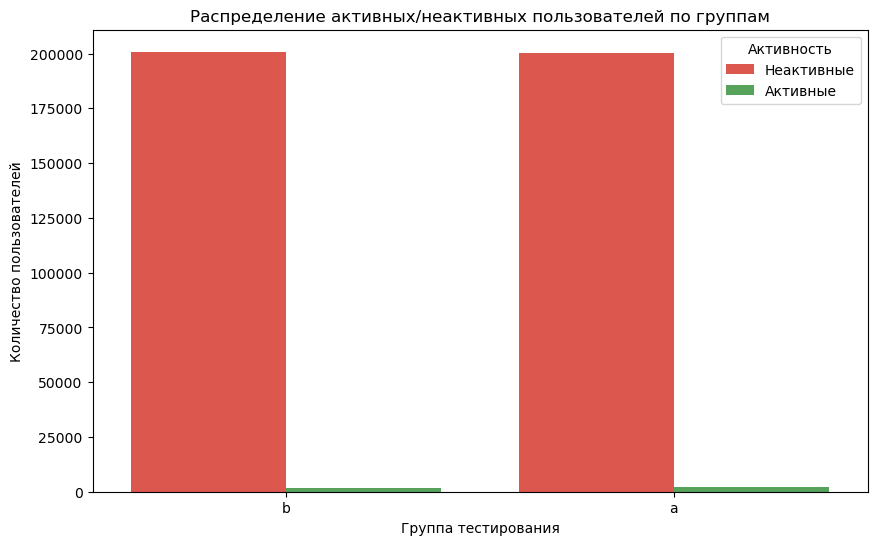

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=A_B, x='testgroup', hue='is_active', 
             palette={True: '#4caf50', False: '#f44336'})

plt.title('Распределение активных/неактивных пользователей по группам')
plt.xlabel('Группа тестирования')
plt.ylabel('Количество пользователей')
plt.legend(title='Активность', labels=['Неактивные', 'Активные'])
plt.show()

Проверим корректность значения revenue. Есть ли в таблице с данными отрицательные значения платежей и выбросы?

In [14]:
A_B[A_B['revenue'] < 0]

,user_id,revenue,testgroup,is_active


Наличие отрицательных значений в платежах исключено.

In [15]:
A_B['revenue'].describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Средний доход (mean): 26.08 на пользователя

Стандартное отклонение (std): 681.65 — очень высокий разброс

Медиана (50%): 0 — подтверждает, что большинство пользователей не платит

Максимум (max): 37433 — потенциальный выброс

Оценим визуально как происходит распределение платежей по группам

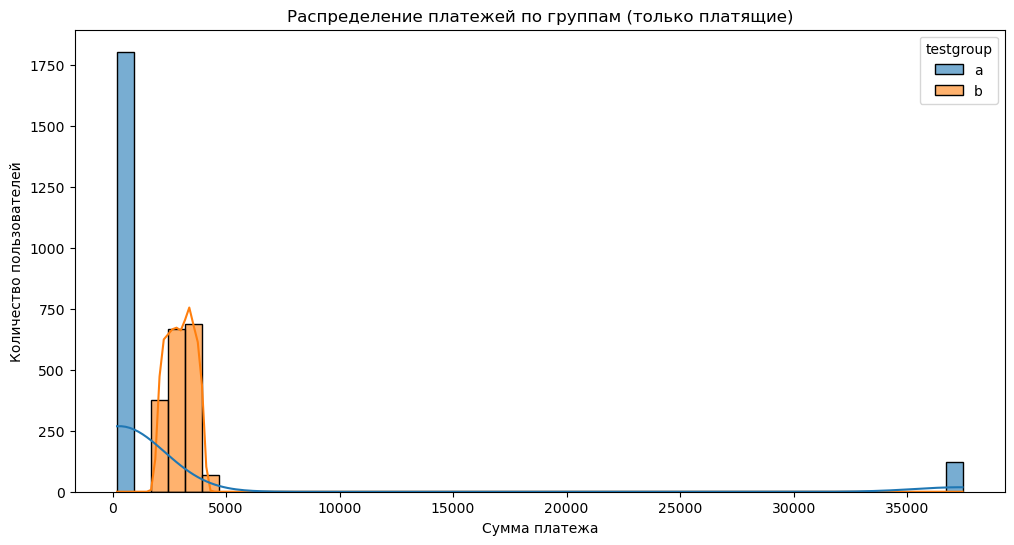

In [16]:
paying_users = A_B[A_B['revenue'] > 0]

plt.figure(figsize=(12, 6))
sns.histplot(
    data=paying_users,
    x='revenue',
    hue='testgroup',
    bins=50,
    alpha=0.6,
    kde=True)

plt.title('Распределение платежей по группам (только платящие)')
plt.xlabel('Сумма платежа')
plt.ylabel('Количество пользователей')
plt.show()

Для лучшей наглядности прологарифмируем значения (так как очень много нулей)

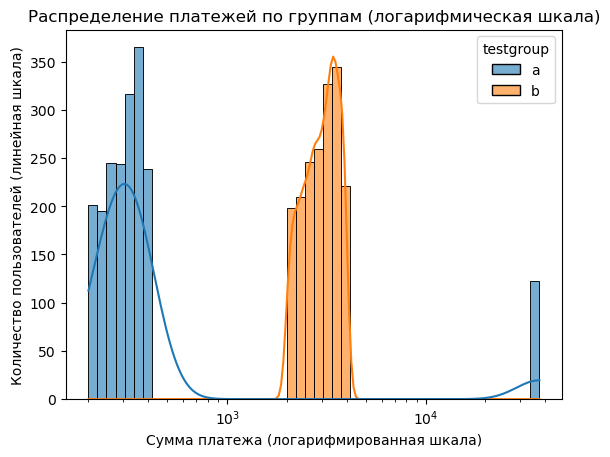

In [17]:
sns.histplot(
    data=A_B[A_B['revenue'] > 0],  # Только платящие
    x='revenue',
    hue='testgroup',
    bins=50,
    log_scale=True,
    alpha=0.6,
    kde=True)

plt.title('Распределение платежей по группам (логарифмическая шкала)')
plt.xlabel('Сумма платежа (логарифмированная шкала)')
plt.ylabel('Количество пользователей (линейная шкала)')
plt.show()

Для группы А:

- Основная масса: много мелких платежей
- Какая-то часть приходися на выбросы
 
Для группы В:

- Платежи сконцентрированы в одном диапазоне
- Нет экстремальных выбросов

Посмотрим на общую статистику для каждой группы конкретно

In [18]:
group_a=A_B.query('testgroup=="a"')
group_a

,user_id,revenue,testgroup,is_active
1,2,0,a,False
2,3,0,a,False
9,10,0,a,False
10,11,0,a,False
11,12,0,a,False
...,...,...,...,...
404760,404761,0,a,False
404762,404763,0,a,False
404765,404766,0,a,False
404767,404768,231,a,True


In [19]:
# Только платящие пользователи в группе А
group_a.query('revenue>0')

,user_id,revenue,testgroup,is_active
72,73,351,a,True
341,342,290,a,True
385,386,250,a,True
416,417,37324,a,True
712,713,255,a,True
...,...,...,...,...
404304,404305,360,a,True
404315,404316,262,a,True
404543,404544,369,a,True
404602,404603,251,a,True


In [20]:
group_b=A_B.query('testgroup=="b"')
group_b

,user_id,revenue,testgroup,is_active
0,1,0,b,False
3,4,0,b,False
4,5,0,b,False
5,6,0,b,False
6,7,0,b,False
...,...,...,...,...
404761,404762,0,b,False
404763,404764,0,b,False
404764,404765,0,b,False
404766,404767,0,b,False


In [21]:
# Только платящие пользователи в группе В
group_b.query('revenue>0')

,user_id,revenue,testgroup,is_active
160,161,3797,b,True
377,378,3768,b,True
386,387,3527,b,True
551,552,2038,b,True
913,914,3902,b,True
...,...,...,...,...
403843,403844,3383,b,True
403994,403995,2793,b,True
404161,404162,2316,b,True
404193,404194,2998,b,True


In [22]:
print(f'{group_a.query('revenue>0').shape[0]} платящих пользователей из {group_a.shape[0]} в группе А')
print(f'{group_b.query('revenue>0').shape[0]} платящих пользователей из {group_b.shape[0]} в группе B')

1928 платящих пользователей из 202103 в группе А
1805 платящих пользователей из 202667 в группе B


Полученные результаты соответствуют изначально заявленным. В контрольной группе (группа А) 1928 игроков из 202103 оказались платящими, а в тестовой (группа В) – 1805 из 202667.

In [23]:
group_a.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [24]:
group_b.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [25]:
(26.751287-25.413720)*100/25.413720

5.263168870987797

In [26]:
920.768137/287.324162

3.204631767097958

Разница в среднем доходе (mean): Группа B показывает на 5.3 более высокое значение, однако разница небольшая (25.41 vs 26.75)

Разница в стандартном отклонении (разброс данных) (std): Группа A имеет в 3.2 раза большее стандартное отклонение (920.77 vs 287.32), это указывает на наличие экстремальных выбросов в группе A (подтверждается максимумом 37433)

Медиана (распределение платежей) (50%): 0 в обеих группах, что большинство пользователей не платит (типично для F2P-игр)

Максимальные платежи (max): 
- Группа A: 37433 (аномально высокий)
- Группа B: 4000 (более реалистично для игровых покупок)

Определим, какую часть составляют выбросы от всех платежей в группе А. Согласно первому графику нижнюю границу для определения % выбросов возьмем 35000. % высчитываться будет только для группы А, так как для группы В выбросы отсутствуют.

In [27]:
blowout=group_a.query('revenue>35000')
blowout

,user_id,revenue,testgroup,is_active
416,417,37324,a,True
4428,4429,37304,a,True
5777,5778,37315,a,True
8065,8066,37307,a,True
8743,8744,37334,a,True
...,...,...,...,...
360696,360697,37347,a,True
378668,378669,37297,a,True
389341,389342,37298,a,True
394580,394581,37302,a,True


In [28]:
# Платящие пользователи в группе А без выбросов
group_a.query('revenue>0 & revenue<=35000').shape[0]

1805

In [29]:
round(((blowout).shape[0]*100/group_a.query('revenue>0 & revenue<=35000').shape[0]),2)

6.81

In [30]:
round(((blowout).shape[0]*100/group_a.shape[0]),2)

0.06

В группе А на 1805 платежа выбросы составляют 123 или 6,81% от всех платящих или 0,06 от всего числа в группе. Посмотрим на распределение этих выбросов

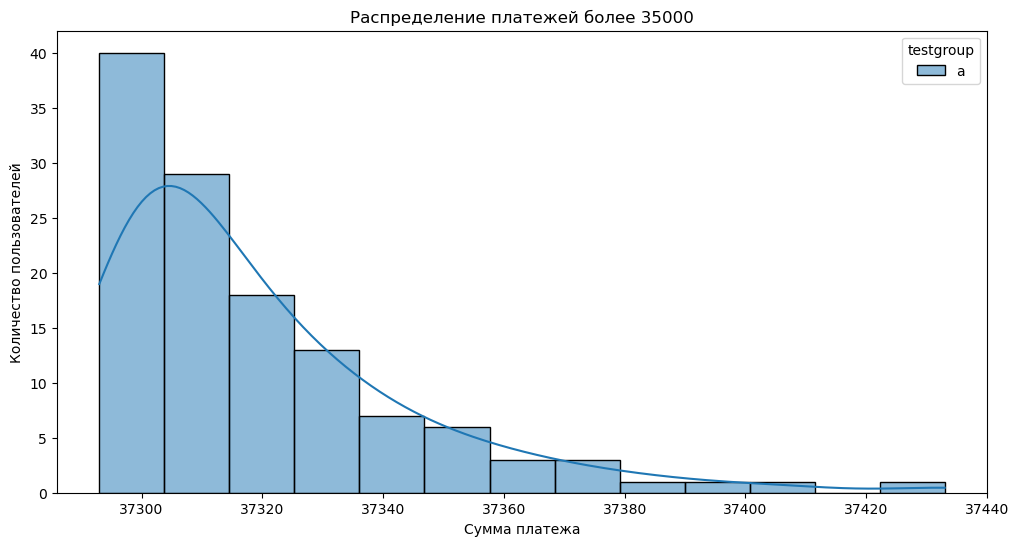

In [31]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=blowout,
    x='revenue',
    hue='testgroup',
    kde=True)

plt.title('Распределение платежей более 35000')
plt.xlabel('Сумма платежа')
plt.ylabel('Количество пользователей')
plt.show()

А как распределяются платежи без учета выбросов для обеих групп?

In [32]:
no_blowout=group_a.query('revenue>0 & revenue<=35000')
no_blowout

,user_id,revenue,testgroup,is_active
72,73,351,a,True
341,342,290,a,True
385,386,250,a,True
712,713,255,a,True
1346,1347,230,a,True
...,...,...,...,...
404304,404305,360,a,True
404315,404316,262,a,True
404543,404544,369,a,True
404602,404603,251,a,True


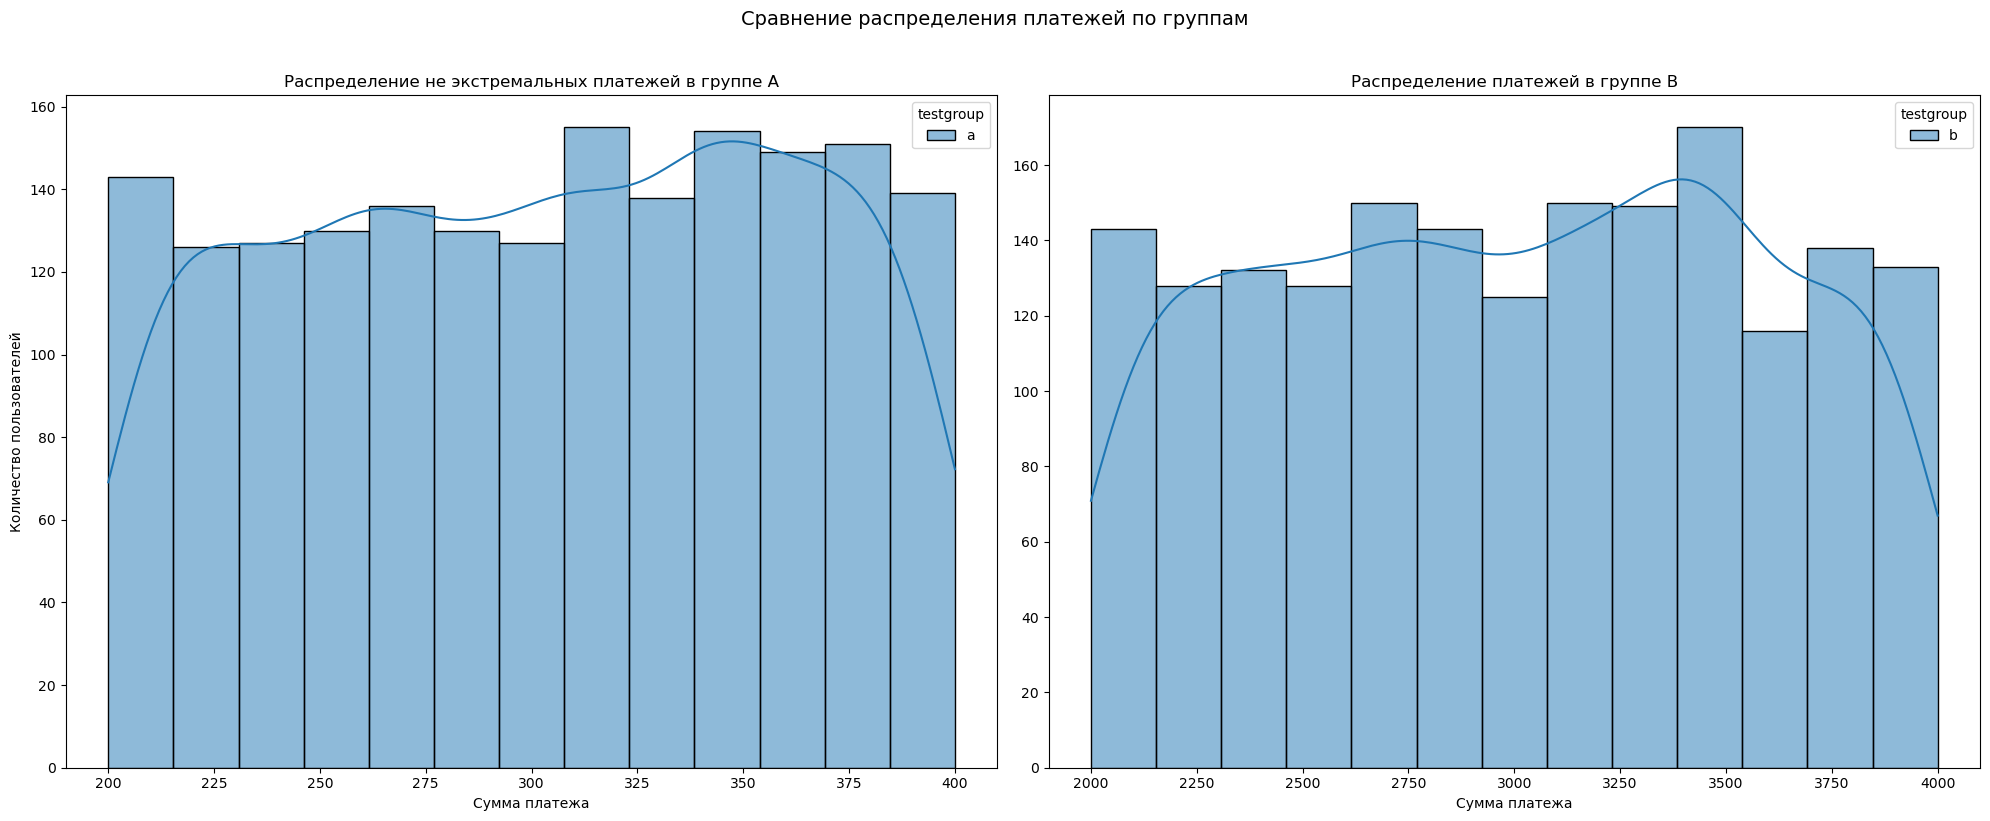

In [33]:
# Создаем фигуру с двумя subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Первый график (группа A) 
sns.histplot(
    data=no_blowout,
    x='revenue',
    hue='testgroup',
    kde=True,
    ax=ax1  
)
ax1.set_title('Распределение не экстремальных платежей в группе A')
ax1.set_xlabel('Сумма платежа')
ax1.set_ylabel('Количество пользователей')

# Второй график (группа B)
sns.histplot(
    data=group_b.query('revenue>0'),
    x='revenue',
    hue='testgroup',
    kde=True,
    ax=ax2  
)
ax2.set_title('Распределение платежей в группе B')
ax2.set_ylabel('') 
ax2.set_xlabel('Сумма платежа')


plt.suptitle('Сравнение распределения платежей по группам', y=1.02, fontsize=14)
plt.tight_layout() 
plt.show()

Проанализируем показатели описательной статистики для платежей, которые больше нуля и не содержат выбросов.

In [34]:
A_B_new=A_B.query('revenue>0 & revenue<=35000')

In [35]:
A_B_new.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1805.0,302.458172,57.914246,200.0,254.0,305.0,352.0,400.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Статистика по группам, включающая только тех пользователей, которые вносят оплату, без учёта аномальных значений:

1. Существенная разница в средних платежах:
- Группа A: Средний платёж 302.46 (медиана 305)
- Группа B: Средний платёж 3003.66 (медиана 3022)

Разница: Пользователи группы B платят почти в 10 раз больше 

2. Распределение платежей:
- Обе группы демонстрируют нормальное распределение с близкими значениями mean/median (малая асимметрия)
- Стандартное отклонение:
  - Группа A: 57.91 (узкий разброс)
  - Группа B: 572.62 (широкий разброс, но пропорционален среднему)

3. Квартальные значения:
- Группа A:
   - 25% пользователей платят <= 254
   - 75% пользователей платят <= 352

- Группа B:
   - 25% пользователей платят <= 2513
   - 75% пользователей платят <= 3478

Принимая во внимание, что в исходных данных в группе А есть аномальные значения у 123 человек, что составляет 0.06%, можно сделать вывод о наличии двух подгрупп в этой группе: более и менее платёжеспособных. Без учёта аномальных значений максимальное значение платежа составляет 400. Платежи группы В более стабильны и находятся в одном диапазоне.

Эти данные свидетельсвуют о некорректном распределении пользователей между группам А и В. Возможно, аномальные пользователи должны были быть изначально в группе В, но из-за бага в алгоритме распределения попали в группу А? На данном этапе разница в средних чеках вызвана не эффективностью теста, а артефактами в формировании групп. 

Необходимо устранить причину появления аномальных значений в группе A: 
- исключить влияние сторонних факторов (время регистрации, гео и т.д.);
- обеспечить идентичные условия для обеих групп.


Предположим, что сложившаяся ситуация была допущена намеренно, оценим результаты проведённого теста с этими данными

# Определение метрик и проверка статистической значимости

Проверим достоверность сведений, данных изначально. ARPU в тестовой группе выше на 5%, чем в контрольной. Проведём расчёт метрики ARPU по каждой из групп.


# ARPU 

Группа А:

In [46]:
# Суммарная выручка в группе А
total_revenue_a=int(paying_user_a.revenue.sum())
total_revenue_a

5136189

In [47]:
# Всего пользователей в группе А
total_users_a=group_a.shape[0]
total_users_a

202103

In [50]:
# Только платящие пользователи в группе А
paying_user_a=group_a.query('revenue > 0').shape[0]
paying_user_a

1928

In [51]:
# ARPU (средняя выручка на пользователя) в группе А
arpu_a=round(total_revenue_a/total_users_a,2)
arpu_a

25.41

In [52]:
# Суммарная выручка в группе B
total_revenue_b=int(paying_user_b.revenue.sum())
total_revenue_b

5421603

In [53]:
# Всего пользователей в группе B
total_users_b=group_b.shape[0]
total_users_b

202667

In [57]:
# Только платящие пользователи в группе B
paying_user_b=group_b.query('revenue > 0').shape[0]
paying_user_b

1805

In [58]:
# ARPU (средняя выручка на пользователя) в группе В
arpu_b=round(total_revenue_b/total_users_b,2)
arpu_b

26.75

In [63]:
difference_arpu = ((arpu_b - arpu_a) / arpu_a) * 100
print(f"Разница ARPU: ARPU группы В больше ARPU группы А на {difference_arpu:.2f}%")

Разница ARPU: ARPU группы В больше ARPU группы А на 5.27%


Полученная разница действительно соответствует заявленному проценту, что подтверждает группа А - контрольная, группа В - тестовая.

В группе, которая участвовала в тестировании, доход больше, чем в контрольной группе, на 5,27%. Однако на данный момент мы не можем утверждать, что тестовый набор акционных предложений лучше.

Проанализируем ключевые показатели, чтобы оценить успешность эксперимента.

- ARPU - средний доход на одного пользователя

- ARPPU - средний доход на одного платящего пользователя


Соотношение ARPU и ARPPU демонстрирует, насколько пользователи удовлетворены ценовой политикой и качеством предлагаемого им платного контента.

Эти метрики относим к целевым метрикам, так как они непосредственно измеряет финансовый результат, то есть демонстрируют успешность эксперимента и соответствуют основным задачам бизнеса.

Также к бизнес-целям можно отнести метрику, показывающую количество платящих людей, так как чем больше число платящих, тем больше итоговая выручка. эта метрика не отражает частоту покупок, размер платежей (средний чек), поэтому будем её использовать как прокси-метрику:


- CR - конверсия в платящего пользователя


Обоснование выбора этих метрик:

1.  ARPU (Average Revenue Per User) Средний доход на одного пользователя, включая неплатящих

- Чувствительность: реагирует на любые изменения: рост числа платящих (↑CR) и увеличение среднего чека (↑ARPPU). Пример: если новая механика привлекает больше мелких платежей, ARPU вырастет даже без изменения ARPPU.
 - Достоверность: зависит от равномерности распределения пользователей между группами. Может "размываться" нулями (неплатящими), поэтому требует дополнения ARPPU.
- Интерпретируемость: прямая связь с выручкой: «Каждый пользователь приносит в среднем X$». Понятна бизнесу как ключевой KPI.

Связь с бизнес-целью:

- Прямо отвечает на вопрос «Увеличился ли общий доход на пользователя?».
- Если цель — общий рост выручки, ARPU — основная метрика.

Ограничения:

- Чувствителен к выбросам (крупные платежи искажают среднее).
- Решение: Дополнять медианой и анализом распределения.


2. ARPPU (Average Revenue Per Paying User) Средний доход только с платящих пользователей.

- Чувствительность: улавливает изменения в платежном поведении: рост среднего чека, эффект от премиум-услуг или скидок. Пример: если новая механика стимулирует крупные платежи, ARPPU вырастет даже при снижении CR.
- Достоверность	Устойчив к неплатящим пользователям (в отличие от ARPU). Но уязвим к выбросам.
- Интерпретируемость: четко отвечает: «Сколько в среднем платят те, кто решил купить». Понятна для анализа ценовой политики.

Связь с бизнес-целью:

- Показывает, стала ли новая механика мотивировать пользователей платить больше.
- Критична, если CR уже высокий, и нужно увеличить средний чек.

Ограничения:

- Не учитывает конверсию в покупку.
- Решение: Комбинировать с CR и проверять медиану вместо среднего при асимметричных данных.

3. CR (Conversion Rate) Доля пользователей, совершивших покупку.

- Чувствительность: показывает, как изменения в интерфейсе/механике влияют на решение о покупке. Пример: упрощение платежного процесса может резко увеличить CR.
- Достоверность: цстойчива к размеру платежей (работает только с бинарным исходом: «платил/не платил»).
- Интерпретируемость	Проста: «X% пользователей совершили покупку». Понятна даже неаналитикам.

Связь с бизнес-целью:

- Ответ на вопрос «Стало ли больше пользователей платить?».
- Ключевая метрика, если цель — привлечение новых платящих.

Ограничения:

- Не отражает размер платежей. Рост CR может маскировать снижение ARPPU.
- Решение: Всегда анализировать вместе с ARPPU.

Почему именно эта тройка метрик?

Взаимодополняемость:

ARPU = CR × ARPPU. Если растет CR или ARPPU, ARPU тоже растет.

Пример:

- CR ↗ + ARPPU → Успех (больше платящих + они платят больше).
- CR ↗ + ARPPU ↘ → Риск (привлекли «дешевых» пользователей).

Контроль искажений:

- ARPU и ARPPU чувствительны к выбросам → дополняем медианой.
- CR неустойчива к сегментации → проверяем баланс групп.

# ARPPU

In [65]:
# ARPPU (средняя выручка на платящего пользователя) в группе А
arppu_a=round(total_revenue_a/paying_user_a,2)
arppu_a

2664.0

In [66]:
# ARPPU (средняя выручка на платящего пользователя) в группе B
arppu_b=round(total_revenue_b/paying_user_b,2)
arppu_b

3003.66

In [64]:
difference_arppu = ((arppu_b - arppu_a) / arppu_a) * 100
print(f"Разница ARPPU: ARPPU группы В больше ARPPU группы А на {difference_arppu:.2f}%")

Разница ARPPU: ARPPU группы В больше ARPPU группы А на 12.75%


# CR

In [73]:
# CR(конверсия в платящего пользователя) в группе А
cr_a=round(paying_user_a*100/total_users_a,2)
cr_a

0.95

In [74]:
# CR(конверсия в платящего пользователя) в группе В
cr_b=round(paying_user_b*100/total_users_b,2)
cr_b

0.89

In [76]:
difference_arppu = ((cr_a - cr_b) / cr_b) * 100
print(f"Разница CR: CR группы В меньше CR группы А на {difference_arppu:.2f}%")

Разница CR: CR группы В меньше CR группы А на 6.74%


Предварительные выводы по всем метрикам:

In [77]:
print(f"Разница ARPU: ARPU группы В больше ARPU группы А на {difference_arpu:.2f}%")
print(f"Разница ARPPU: ARPPU группы В больше ARPPU группы А на {difference_arppu:.2f}%")
print(f"Разница CR: CR группы В меньше CR группы А на {difference_arppu:.2f}%")

Разница ARPU: ARPU группы В больше ARPU группы А на 5.27%
Разница ARPPU: ARPPU группы В больше ARPPU группы А на 6.74%
Разница CR: CR группы В меньше CR группы А на 6.74%


Прежде чем выдвигать гипотезы, необходимо правильно выбрать статистический тест. Тест будет проводиться среди двух выборок, поэтому выбор среди двухвыборочных тестов.

Сравнивают средние двух выборок.

- t-критерий Стьюдента для независимых выборок

   - Условия:

       - Независимые выборки.

       - Нормальное распределение или большой объем выборки.

       - Проверка равенства дисперсий (критерий Левена или F-тест).

   - Варианты:

       - С равными дисперсиями (критерий Стьюдента).

       - С неравными дисперсиями (критерий Уэлча).

- t-критерий Стьюдента для парных выборок

   - Условия:

       - Зависимые выборки (например, до и после воздействия).

       - Разности пар должны быть нормально распределены.

- U-критерий Манна-Уитни (непараметрический аналог t-теста)

   - Условия:

       - Ненормальное распределение.

       - Независимые выборки.

   - Проверяет гипотезу о равенстве медиан или сдвиге распределений.

- Критерий Уилкоксона (парный непараметрический тест)

   - Аналог парного t-теста для ненормальных данных.
 

Для достоверной оценки статистической значимости необходимо выбрать правильно тест. 

t-критерий Стьюдента для парных выборок уже не подходит, так как выборки не зависимы медлу собой, поэтому выбираем между:

t-критерий Стьюдента для независимых выборок, U-критерий Манна-Уитни (непараметрический аналог t-теста) и Критерий Уилкоксона (парный непараметрический тест, аналог парного t-теста для ненормальных данных). 

Согласно условиям t-критерий Стьюдента для независимых выборок (а выборки в нашем случае друг от лруга независимы, значит первое условие уже выполнено), нужно провести проверку распределения данных на нормальность и провести проверку равенства дисперсий (критерий Левена или F-тест).


U-критерий Манна-Уитни (непараметрический аналог t-теста) - выборки независимы, поэтому также как и с Т-тестом нужно проверить нормальность распределения данных.

Критерий Уилкоксона (парный непараметрический тест) - данные распределены ненормально либо это неизвестно.


# ARPU

Для проверки на нормальность распределения данных применим тест нормальности Д'Агостино-Пирсона 

Нулевая гипотеза - данные распределены нормально. 

Альтернативная гипотеза - данные распределены ненормально.

Если p-значение < 0,05 (5%), нулевая гипотеза отвергается, распределение не является нормальным.


In [106]:
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind
from scipy.stats import normaltest

In [107]:
arpu__a = A_B[A_B['testgroup'] == 'a']['revenue']
arpu__b = A_B[A_B['testgroup'] == 'b']['revenue']

In [119]:
# Проведем тест Д'Агостино-Пирсона
stat_a1, p_a1 = normaltest(arpu__a)
stat_b1, p_b1 = normaltest(arpu__b)

In [120]:
print(f"""
Результаты теста Д'Агостино-Пирсона:

Группа A:
- Статистика: {stat_a1:.4f}
- p-value: {p_a1:.4f}
- Нормальность: {'Распределение нормально' if p_a1 > 0.05 else 'Распределение не нормально'}

Группа B:
- Статистика: {stat_b1:.4f}
- p-value: {p_b1:.4f}
- Нормальность: {'Распределение нормально' if p_b1 > 0.05 else 'Распределение не нормально'}
""")


Результаты теста Д'Агостино-Пирсона:

Группа A:
- Статистика: 585152.7313
- p-value: 0.0000
- Нормальность: Распределение не нормально

Группа B:
- Статистика: 326622.3954
- p-value: 0.0000
- Нормальность: Распределение не нормально



В результате теста Д'Агостино-Пирсона принимается альтернативная гипотеза о ненормальности данных во всех группах, так как и p-значение < 0,05.
Необходимо проверить равенство дисперсий.


Критерии для проверки гипотез о дисперсиях

- F-тест (критерий Фишера)

  - Сравнивает дисперсии двух выборок.

  - Условия: нормальное распределение.

- Критерий Бартлетта / Левена

  - Проверяет равенство дисперсий нескольких выборок.

  - Бартлетт чувствителен к отклонениям от нормальности, Левен более устойчив
  
На основе теоретической справки, для проверки равенства дисперсий будем использовать критерий Левена с медианной центровкой, так как распределение данных ненормально.

Нулевая гипотеза - дисперсии двух групп равны

Альтернативная гипотеза - дисперсии двух групп не равны


In [124]:
levene_test_1 = levene(arpu__a, arpu__b, center='median')

In [125]:
print(f"Тест Левена (медианный): p-value = {levene_test_1.pvalue:.4f}")

if levene_test_1.pvalue > 0.05:
    print("Дисперсии можно считать равными (p > 0.05)")
else:
    print("Дисперсии различаются (p <= 0.05)")

Тест Левена (медианный): p-value = 0.5325
Дисперсии можно считать равными (p > 0.05)


Так как дисперсии равны, для проверки статистической значимости будем использовать - t-критерий Стьюдента для независимых выборок.

Проверим значимость ARPU (t-тест):

Нулевая гипотеза: ARPU в группах не различается, а наблюдаемые различия случайны.

Альтернативная гипотеза: ARPU в группах различаюся статистически значимо.

In [114]:
arpu_test = pg.ttest(
    x=A_B[A_B['testgroup'] == 'a']['revenue'],
    y=A_B[A_B['testgroup'] == 'b']['revenue'],
    correction=False)  # Поправка Уэлча не нужна, т.к. дисперсии равны

In [115]:
print("Результаты t-теста для ARPU:")
print(" ")
print(arpu_test.round(4))
print(" ")

Результаты t-теста для ARPU:
 
             T     dof alternative   p-val          CI95%  cohen-d   BF10  \
T-test -0.6242  404768   two-sided  0.5325  [-5.54, 2.86]    0.002  0.004   

         power  
T-test  0.0957  
 


Основные выводы:

1. Статистическая значимость (p-value = 0.5325)

- p-value > 0.05 → различия в ARPU между группами незначимы.
- Нет оснований отвергать нулевую гипотезу «ARPU групп одинаковы».

2. Размер эффекта (Cohen’s d = 0.002)

- Эффект практически отсутствует (d < 0.2 считается незначимым).
- Даже если бы p-value был < 0.05, такой эффект не имел бы практического смысла.

3. Доверительный интервал (95% ДИ: [-5.54, 2.86])

- Интервал включает ноль → статистически значимых различий нет.
- Максимальная возможная разница: группа B может быть лучше на 2.86 или хуже на 5.54 (но всё в пределах шума).

4. Bayes Factor (BF10 = 0.004)

- Сильно поддерживает нулевую гипотезу (BF < 0.01 — «анемичные доказательства» альтернативы).
- Данные в 250 раз чаще (1/0.004) встречаются при нулевой гипотезе, чем при альтернативной.

5. Мощность теста (Power = 0.0957)

- Всего 9.57% шанс обнаружить эффект, если бы он был (но его нет).

# ARPPU

Определим нормальность распределения данных, равенство дисперсий и выберем тест для оценки статистической значимости для метрики ARPPU

Для проверки на нормальность распределения данных применим тест нормальности Д'Агостино-Пирсона

Нулевая гипотеза - данные распределены нормально.

Альтернативная гипотеза - данные распределены ненормально.

Если p-значение < 0,05 (5%), нулевая гипотеза отвергается, распределение не является нормальным.

In [121]:
arppu__a = A_B[(A_B['testgroup'] == 'a') & (A_B['revenue'] > 0)]['revenue']
arppu__b = A_B[(A_B['testgroup'] == 'b') & (A_B['revenue'] > 0)]['revenue']

In [122]:
stat_a2, p_a2 = normaltest(arppu__a)
stat_b2, p_b2 = normaltest(arppu__b)

In [123]:
print(f"""
Результаты теста Д'Агостино-Пирсона:

Группа A:
- Статистика: {stat_a2:.4f}
- p-value: {p_a2:.4f}
- Нормальность: {'Распределение нормально' if p_a2 > 0.05 else 'Распределение не нормально'}

Группа B:
- Статистика: {stat_b2:.4f}
- p-value: {p_b2:.4f}
- Нормальность: {'Распределение нормально' if p_b2 > 0.05 else 'Распределение не нормально'}
""")


Результаты теста Д'Агостино-Пирсона:

Группа A:
- Статистика: 1394.9458
- p-value: 0.0000
- Нормальность: Распределение не нормально

Группа B:
- Статистика: 1068.8600
- p-value: 0.0000
- Нормальность: Распределение не нормально



В результате теста Д'Агостино-Пирсона принимается альтернативная гипотеза о ненормальности данных во всех группах, так как и p-значение < 0,05. Необходимо проверить равенство дисперсий. Будем использовать критерий Левена.

Нулевая гипотеза - дисперсии двух групп равны

Альтернативная гипотеза - дисперсии двух групп не равны

In [126]:
levene_test_2 = levene(arppu__a, arppu__b, center='median')

In [127]:
print(f"Тест Левена (медианный): p-value = {levene_test_2.pvalue:.4f}")

if levene_test_2.pvalue > 0.05:
    print("Дисперсии можно считать равными (p > 0.05)")
else:
    print("Дисперсии различаются (p <= 0.05)")

Тест Левена (медианный): p-value = 0.0000
Дисперсии различаются (p <= 0.05)


С учетом того, что данные распределены не нормально и дисперсии не равны,  для установления статистической значимости различий метрики ARPPU будем использовать t-критерий Уэлча для сравнения средних с поправкой на неравенство дисперсий, как наиболее устойчивый к отклонениям от нормальности, т.к. в данном случае размеры выборок достаточно велики (1928 и 1805), а значит, с поправкой на разность дисперсии принцип центральной предельной теоремы (о том, что распределение выборочных средних будет стремиться к нормальному, независимо от формы первоначального распределения) всё ещё будет работать.

Нулевая гипотеза: ARPPU в группах не различается, а наблюдаемые различия случайны.

Альтернативная гипотеза: ARPPU в группах различаюся статистически значимо.

In [133]:
welch_test = pg.ttest(
    x=arppu__a,
    y=arppu__b,
    correction=True  # Автоматически применяет поправку Уэлча
)

print("\nРезультаты t-теста с поправкой Уэлча для ARPPU")
print(welch_test.round(4))



Результаты t-теста с поправкой Уэлча для ARPPU
             T        dof alternative   p-val            CI95%  cohen-d  \
T-test -1.6446  1943.4815   two-sided  0.1002  [-744.7, 65.38]   0.0521   

         BF10   power  
T-test  0.142  0.3564  


Основные выводы:

1. Статистическая значимость (p-value = 0.1002)

- p-value > 0.05 → различия в ARPPU не являются статистически значимыми.
- Нет оснований отвергать нулевую гипотезу  «ARPPU групп одинаковы».

2. Размер эффекта (Cohen’s d = 0.0521)

- Эффект крайне мал (d ≈ 0.05). Даже если бы p-value был < 0.05, такой эффект не имел бы практического смысла.

3. Доверительный интервал (95% ДИ: [-744.7, 65.38])

- Интервал включает ноль → статистически значимых различий нет.
- Широкий диапазон (от -744.7 до +65.38) указывает на высокую неопределенность.
    - Возможно, группа B лучше на 65.38 или хуже на 744.7 (но это в пределах погрешности).

4. Bayes Factor (BF10 = 0.142)

- Данные в 7 раз чаще (1/0.142 ≈ 7) встречаются при нулевой гипотезе, чем при альтернативной.

5. Мощность теста (Power = 0.3564)

- Всего 35.64% шанс обнаружить эффект, если он есть (обычно целевой порог — 80%).
- Низкая мощность объясняется:
    - Малым размером эффекта (d = 0.05),
    - Возможной большой дисперсией в данных.

# CR

In [135]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

CR — бинарная метрика (0 или 1), которая:

Подчиняется биномиальному распределению, а не нормальному, бинарные данные заведомо ненормальны.

Имеет фиксированную дисперсию для каждой группы

«Для пропорций (бинарных данных) z-тест и хи-квадрат являются стандартными методами, не требующими проверки нормальности»
— Agresti, A. (2013). Categorical Data Analysis.



Для проверки наличия статистически значимых различий в CR между двумя группами обычно используют z-test для двух пропорций.
Гипотезы:

Нулевая гипотеза - CR в группах не различается, а наблюдаемые различия случайны.

Альернативная гипотеза - CR в группах различаюся статистически значимо.

In [137]:
A_B['converted'] = (A_B['revenue'] > 0).astype(int)  # 1 — платящий, 0 — нет
conversions = A_B.groupby('testgroup')['converted'].agg(['sum', 'count'])
conversions.columns = ['converted', 'total']

In [139]:
count = conversions.loc['a', 'converted'], conversions.loc['b', 'converted']
nobs = conversions.loc['a', 'total'], conversions.loc['b', 'total']

In [140]:
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
print(f"\nРезультаты z-теста:\nz-статистика = {z_stat:.4f}, p-value = {p_value:.4f}")


Результаты z-теста:
z-статистика = 2.1080, p-value = 0.0350


In [142]:
p_a = count[0] / nobs[0]  
p_b = count[1] / nobs[1]  
h = 2 * (np.arcsin(np.sqrt(p_a)) - np.arcsin(np.sqrt(p_b)))
print(f"Cohen’s h = {h:.3f}")  

Cohen’s h = 0.007


p-value < 0.05 поэтому нулевую гипотезу отклоняем, различия между группами статистически значимы, что говорит нам о том, что конверсия в покупку у контрольной группы действительно выше, чем конверсия тестовой группы. Однако размер эффекта (h = 0.007) ничтожно мал, хоть z-тест и видит значимость, практическое значение для бизнеса отсутствует.

# Общие итоги A/B-теста

Ключевые проблемы
- Группа A содержит крайне неравномерное распределение платежей:
    - Большая часть пользователей не платит.
    - 6% "китов" (платежи до 37 433 руб.) искусственно завышают ARPU/ARPPU.

- Группа B более однородна (платежи до 4000 руб.), но её ARPU тоже требует проверки.



1. ARPU (Average Revenue Per User) средний доход на одного пользователя
- Результат: Нет статистически значимых различий (p = 0.5325),
- Размер эффекта: Ничтожно мал (Cohen’s d = 0.002),
- Практический вывод: Изменения не повлияли на средний доход с пользователя. Различия в пределах статистического шума.

2. ARPPU (Average Revenue Per Paying User) средний доход на одного платящего пользователя
- Результат: Нет статистически значимых различий (p = 0.1002),
- Размер эффекта: Очень мал (Cohen’s d = 0.052),
- Практический вывод: Платящие пользователи в обеих группах тратят одинаково. Широкий доверительный интервал (от -744.7 до +65.38) указывает на неопределённость, но даже в лучшем случае эффект минимален.

3. CR (Conversion Rate) конверсия в платящего полльзователя
- Результат: Статистически значимые различия (p = 0.035),
- Размер эффекта: Ничтожно мал (Cohen’s h = 0.007),
- Практический вывод: Конверсия в группе A значимо выше, но разница всего ~0.07% — не имеет практического смысла для бизнеса.


# Итоговые рекомендации

Проведенный A/B-тест не выявил статистически и практически значимых и практически различий между группами по ключевым метрикам (ARPU, ARPPU, CR). Наблюдаемый рост ARPU на 5% в группе B может быть связан с случайными колебаниями или артефактами данных (например, выбросами в группе A). 

Рекомендуется:

1. Исключить аномальные платежи, убедиться, что пользователи с большими платежами равномерно распределены между группами и перезапустить тест для чистоты эксперимента.
2. Увеличить длительность теста и объем выборки для повышения мощности анализа.


На текущем этапе внедрение изменений группы B не обосновано.